# 该笔记介绍如何使用CNN构建推荐模型

## 1. 准备数据

#### 1.1 下载数据

In [1]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

--2019-11-30 12:29:27--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  1.99MB/s    in 2.8s    

2019-11-30 12:29:30 (1.99 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]



In [2]:
!unzip ml-1m.zip

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


#### 1.2 使用pandas加载数据并作简单分析

movielens数据集有很多，数据内容及格式大家可以参考README.txt或者自行搜索了解。此处使用ml-1m数据集，主要用到其中的用户信息，电影信息和用户对电影评分的信息

In [167]:
#!cat ml-1m/README

In [1]:
import numpy as np
import pandas as pd

In [2]:
!tail -2 ml-1m/movies.dat

3951::Two Family House (2000)::Drama
3952::Contender, The (2000)::Drama|Thriller


In [3]:
!tail -2 ml-1m/ratings.dat

6040::1096::4::956715648
6040::1097::4::956715569


In [4]:
!tail -2 ml-1m/users.dat

6039::F::45::0::01060
6040::M::25::6::11106


#### 1.2.1 先用pandas加载电影信息

In [5]:
df_movies = pd.read_csv('ml-1m/movies.dat', header=None, sep='::', engine= 'python')
df_movies.columns = ['movieId','title','genres']

In [6]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
movieId    3883 non-null int64
title      3883 non-null object
genres     3883 non-null object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


- 一共有3883条电影数据

In [7]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


- 可利用的电影信息主要有电影名称和电影类别，一个电影有多个类别标签，用`|`分割

#### 1.2.2 加载打分信息

In [8]:
df_ratings = pd.read_csv('ml-1m/ratings.dat', sep = '::', header = None, engine = 'python')
df_ratings.columns = ['userId','movieId','tag','timestamp']

In [9]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
userId       1000209 non-null int64
movieId      1000209 non-null int64
tag          1000209 non-null int64
timestamp    1000209 non-null int64
dtypes: int64(4)
memory usage: 30.5 MB


- 评分数据有100W+

In [10]:
df_ratings.head()

,userId,movieId,tag,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [11]:
df_users = pd.read_csv('ml-1m/users.dat', sep = '::', header = None, engine = 'python')
df_users.columns = ['userId', 'gender', 'age', 'occupation', 'zip-code']

In [12]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
userId        6040 non-null int64
gender        6040 non-null object
age           6040 non-null int64
occupation    6040 non-null int64
zip-code      6040 non-null object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [13]:
df_users.head()

,userId,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


#### 1.2.3 简单查看一下统计信息

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

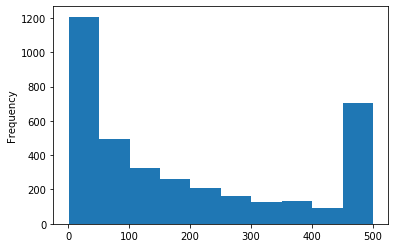

In [15]:
df_ratings['movieId'].value_counts().clip(0, 500).plot.hist()

- 存在一些电影，其被评价的个数非常少，这种极度稀疏的数据可以去掉

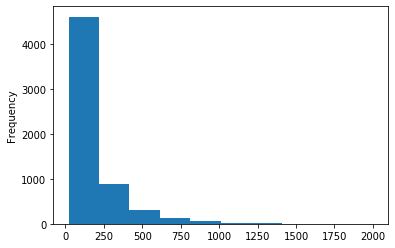

In [16]:
df_ratings['userId'].value_counts().clip(0, 2000).plot.hist()

In [17]:
df_ratings['userId'].value_counts().tail()

761     20
1493    20
5533    20
2714    20
2696    20
Name: userId, dtype: int64

- 从用户维度来看，评价最少的用户评价数量为20，数据还算可以

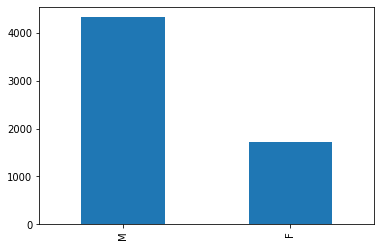

In [18]:
df_users['gender'].value_counts().plot.bar()

- 男性用户与女性用户的比例为 2：1

#### 1.3 对数据特征进行加工

考虑到电影信息中的`title`和`genres`字段值为字符串，其表示的信息为复合信息，需要进行拆解

In [96]:
def prepare_data(df_users, df_movies, df_ratings):
    import re
    df_users = df_users.copy()
    df_movies = df_movies.copy()
    df_ratings = df_ratings.copy()
    df_movies['year'] = df_movies['title'].map(lambda x : int(re.findall(r'\((\d+)\)', x)[0]))
    df_movies['title'] = df_movies['title'].map(lambda x : re.findall(r'(.*) \(', x)[0])
    df_movies['genres'] = df_movies['genres'].map(lambda x : x.split('|'))
    genres_dict = {}
    for i, genres in enumerate(list(set(df_movies['genres'].sum()))):
        genres_dict[genres] = i + 1
    df_movies['genres'] = df_movies['genres'].map(lambda x : [genres_dict[xx] for xx in x])
    df_users['gender'] = df_users['gender'].map(lambda x : {'F':0, 'M':1}[x])
    #df_users = pd.get_dummies(df_users, columns = ['gender'])
    age_bins = [0, 20, 30, 40, 50, 200]
    df_users['age'] = pd.cut(df_users['age'], age_bins, labels = list(range(5)))
    #df_users = pd.get_dummies(df_users, columns = ['age'])
    df_ratings_users = pd.merge(df_ratings, df_users, on = 'userId')
    df_ratings_users_movies = pd.merge(df_ratings_users, df_movies, on = 'movieId')
    # 用户数据
    #users_cols = ['userId', 'gender', 'age']
    X_users_id = df_ratings_users_movies[['userId']].values
    X_users_gender = df_ratings_users_movies[['gender']].values
    X_users_age = df_ratings_users_movies[['age']].values
    # 电影数据(ID)
    X_movies_id = df_ratings_users_movies[['movieId']].values
    # 电影数据(类型)
    from keras.preprocessing.sequence import pad_sequences
    X_movies_genres = pad_sequences(np.array(df_ratings_users_movies['genres'].values.tolist()), padding = 'post')
    # 电影数据（标题）
    from keras.preprocessing.text import Tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df_ratings_users_movies['title'])
    X_movies_title = tokenizer.texts_to_sequences(df_ratings_users_movies['title'])
    X_movies_title = pad_sequences(X_movies_title, padding = 'post')
    # 样本标签
    y = df_ratings_users_movies[['tag']].values
    users_id_size = df_users['userId'].max()
    movies_id_size = df_movies['movieId'].max()
    return X_users_id, X_users_gender, X_users_age, X_movies_id, X_movies_genres, X_movies_title, y, \
            users_id_size, movies_id_size, genres_dict, age_bins, tokenizer.word_index

In [97]:
X_users_id, X_users_gender, X_users_age, X_movies_id, X_movies_genres, X_movies_title, y, \
users_id_size, movies_id_size, genres_dict, age_bins, title_word_index = prepare_data(df_users, df_movies, df_ratings)

## 2. 训练模型

- 模型采用神经网络模型，用户特征和电影特征分别训练出两个向量，两个向量之间作内积去预测打分标签。
- 除去电影中的title属性使用卷积运算，其它的特征均作Embedding

#### 2.1 Baseline 模型

In [112]:
def build_model(users_id_size, age_size, movies_id_size, genres_n, genres_len, title_n, title_len):
    import keras
    from keras.layers import Input, Dense, Embedding, Flatten, Reshape, Conv1D, MaxPooling1D, Lambda
    from keras.models import Model
    import keras.backend as K
    
    input_users_id = Input(shape = (1,), name = 'users_id')
    input_users_gender = Input(shape = (1,), name = 'users_gender')
    input_users_age = Input(shape = (1,), name = 'users_age')
    
    embedding_users_id = Embedding(users_id_size, 32)(input_users_id)
    embedding_users_id = Flatten()(embedding_users_id)
    embedding_users_gender = Embedding(2, 16)(input_users_gender)
    embedding_users_gender = Flatten()(embedding_users_gender)
    embedding_users_age = Embedding(age_size, 16)(input_users_age)
    embedding_users_age = Flatten()(embedding_users_age)
    
    layer = keras.layers.concatenate([embedding_users_id, embedding_users_gender, embedding_users_age])
    layer = Dense(128, activation = 'relu')(layer)
    user_layer = Dense(200, activation = 'relu')(layer)
    
    input_movies_id = Input(shape = (1,), name = 'movies_id')
    input_movies_genres = Input(shape = (genres_len,), name = 'movies_genres')
    input_movies_title = Input(shape = (title_len,), name = 'movies_title')
    
    embedding_movies_id = Embedding(movies_id_size, 32)(input_movies_id)
    embedding_movies_id = Flatten()(embedding_movies_id)
    embedding_movies_genres = Embedding(genres_n, 32, input_length = genres_len)(input_movies_genres)
    embedding_movies_genres = Lambda(lambda x : K.sum(x, axis = 1, keepdims = False), output_shape=(32,))(embedding_movies_genres)
    layer = keras.layers.concatenate([embedding_movies_id, embedding_movies_genres])
    movies_layer = Dense(64, activation = 'relu')(layer)
    
    embedding_movies_title = Embedding(title_n, 32, input_length = title_len)(input_movies_title)
    window_sizes = {2, 3, 4, 5}
    conv_list = []
    for window in window_sizes:
        movies_title_conv = Conv1D(filters = 16, kernel_size = window,
                                 padding = 'valid', activation = 'relu',
                                 strides = 1)(embedding_movies_title)
        movies_title_conv = MaxPooling1D(pool_size = (title_len - window + 1))(movies_title_conv)
        movies_title_conv = Flatten()(movies_title_conv)
        conv_list.append(movies_title_conv)
        
    conv_layer = keras.layers.concatenate(conv_list)
    movie_layer = keras.layers.concatenate([movies_layer, conv_layer])
    movie_layer = Dense(200, activation = 'relu')(movie_layer)
    
    output_layer = keras.layers.dot([user_layer, movie_layer], axes = 1)
    
    model = Model(inputs = [input_users_id, input_users_gender, input_users_age, \
                            input_movies_id,input_movies_genres, input_movies_title], output = output_layer)
    
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    return model

In [114]:
model = build_model(users_id_size + 1, len(age_bins) - 1, movies_id_size + 1, 
                    len(genres_dict) + 1, X_movies_genres.shape[1], len(title_word_index) + 1, X_movies_title.shape[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("do...)`


In [100]:
#model.summary()

In [165]:
def train(model, X_users_id, X_users_gender, X_users_age, X_movies_id, X_movies_genres, X_movies_title, y):
    hist = model.fit([X_users_id, X_users_gender, X_users_age, X_movies_id, X_movies_genres, X_movies_title], 
              y, epochs = 10, batch_size = 32, validation_split = 0.3, shuffle = True)
    return hist

In [116]:
hist = train(model, X_users_id, X_users_gender, X_users_age, X_movies_id, X_movies_genres, X_movies_title, y)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 700146 samples, validate on 300063 samples
Epoch 1/10
700146/700146 [==============================] - 45s 65us/step - loss: 0.8906 - val_loss: 1.2053
Epoch 2/10
700146/700146 [==============================] - 45s 64us/step - loss: 0.7701 - val_loss: 1.1982
Epoch 3/10
700146/700146 [==============================] - 45s 64us/step - loss: 0.7302 - val_loss: 1.2391
Epoch 4/10
700146/700146 [==============================] - 44s 64us/step - loss: 0.7067 - val_loss: 1.1910
Epoch 5/10
700146/700146 [==============================] - 45s 64us/step - loss: 0.6891 - val_loss: 1.1888
Epoch 6/10
700146/700146 [==============================] - 44s 63us/step - loss: 0.6753 - val_loss: 1.1849
Epoch 7/10
700146/700146 [==============================] - 45s 64us/step - loss: 0.6634 - val_loss: 1.2095
Epoch 8/10
700146/700146 [==============================] - 45s 65us/step - loss: 0.6531 - val_loss: 1.1857
Epoch 9/10
700146/700146 [==============================] - 45s 64us/step - loss: 0.

- 虽然训练集的误差随着轮次在不断减小，但是第二轮以后，测试集误差却不降反升，说明模型的泛化能力不强

In [152]:
from keras.layers import Dense

#### 2.2 优化版本（提高模型的泛化能力）

In [161]:
def build_model(users_id_size, age_size, movies_id_size, genres_n, genres_len, title_n, title_len):
    import keras
    from keras.layers import Input, Dense, Embedding, Flatten, Reshape, Conv1D, MaxPooling1D, Lambda, Activation, Dropout
    from keras.layers.normalization import BatchNormalization
    from keras.optimizers import Adam
    from keras.models import Model
    from keras.regularizers import l2
    import keras.backend as K
    
    input_users_id = Input(shape = (1,), name = 'users_id')
    input_users_gender = Input(shape = (1,), name = 'users_gender')
    input_users_age = Input(shape = (1,), name = 'users_age')
    
    embedding_users_id = Embedding(users_id_size, 32)(input_users_id)
    embedding_users_id = Flatten()(embedding_users_id)
    embedding_users_gender = Embedding(2, 16)(input_users_gender)
    embedding_users_gender = Flatten()(embedding_users_gender)
    embedding_users_age = Embedding(age_size, 16)(input_users_age)
    embedding_users_age = Flatten()(embedding_users_age)
    
    layer = keras.layers.concatenate([embedding_users_id, embedding_users_gender, embedding_users_age])
    layer = Dense(128, activation = 'relu')(layer)
    layer = Dropout(0.1)(layer)
    user_layer = Dense(200, activation = 'sigmoid')(layer)
    
    input_movies_id = Input(shape = (1,), name = 'movies_id')
    input_movies_genres = Input(shape = (genres_len,), name = 'movies_genres')
    input_movies_title = Input(shape = (title_len,), name = 'movies_title')
    
    embedding_movies_id = Embedding(movies_id_size, 32)(input_movies_id)
    embedding_movies_id = Flatten()(embedding_movies_id)
    embedding_movies_genres = Embedding(genres_n, 32, input_length = genres_len)(input_movies_genres)
    embedding_movies_genres = Lambda(lambda x : K.sum(x, axis = 1, keepdims = False), output_shape=(32,))(embedding_movies_genres)
    layer = keras.layers.concatenate([embedding_movies_id, embedding_movies_genres])
    movies_layer = Dense(64, activation = 'relu')(layer)
    movies_layer = Dropout(0.1)(movies_layer)
    
    embedding_movies_title = Embedding(title_n, 32, input_length = title_len)(input_movies_title)
    window_sizes = {2, 3, 4, 5}
    conv_list = []
    for window in window_sizes:
        movies_title_conv = Conv1D(filters = 16, kernel_size = window,
                                 padding = 'valid',
                                 strides = 1, kernel_initializer = 'he_normal',
                                  kernel_regularizer = l2(1e-4))(embedding_movies_title)
        movies_title_conv = BatchNormalization(axis = 2)(movies_title_conv)
        movies_title_conv = Activation('relu')(movies_title_conv)
        movies_title_conv = MaxPooling1D(pool_size = (title_len - window + 1))(movies_title_conv)
        movies_title_conv = Flatten()(movies_title_conv)
        conv_list.append(movies_title_conv)
        
    conv_layer = keras.layers.concatenate(conv_list)
    movie_layer = keras.layers.concatenate([movies_layer, conv_layer])
    movie_layer = Dense(200, activation = 'sigmoid')(movie_layer)
    
    output_layer = keras.layers.dot([user_layer, movie_layer], axes = 1)
    
    model = Model(inputs = [input_users_id, input_users_gender, input_users_age, \
                            input_movies_id,input_movies_genres, input_movies_title], output = output_layer)
    
    optimizer = Adam(lr = 0.0001)
    model.compile(optimizer = optimizer, loss = 'mean_squared_error')
    
    return model

In [162]:
model = build_model(users_id_size + 1, len(age_bins) - 1, movies_id_size + 1, 
                    len(genres_dict) + 1, X_movies_genres.shape[1], len(title_word_index) + 1, X_movies_title.shape[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("do...)`


In [ ]:
hist = train(model, X_users_id, X_users_gender, X_users_age, X_movies_id, X_movies_genres, X_movies_title, y)

Train on 700146 samples, validate on 300063 samples
Epoch 1/10
700146/700146 [==============================] - 189s 270us/step - loss: 0.7733 - val_loss: 1.2930
Epoch 2/10
700146/700146 [==============================] - 189s 270us/step - loss: 0.7648 - val_loss: 1.2761
Epoch 3/10
700146/700146 [==============================] - 189s 271us/step - loss: 0.7568 - val_loss: 1.2595
Epoch 4/10
700146/700146 [==============================] - 189s 270us/step - loss: 0.7479 - val_loss: 1.3080
Epoch 5/10
441888/700146 [=================>............] - ETA: 1:06 - loss: 0.7384

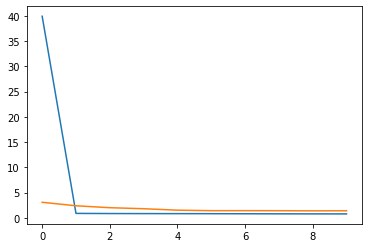

In [164]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])